<a href="https://colab.research.google.com/github/Clarke-Group-Computational-Projects/experimental-design-notebooks/blob/main/angle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qqq corner==2.1.0 dynesty==1.0.1 matplotlib==3.2.2 Pillow
!pip install -qqq --no-binary "refnx, refl1d" refnx==0.1.19 refl1d==0.8.14
!git clone https://github.com/James-Durant/experimental-design.git --depth 1
import sys
sys.path.append("/content/experimental-design/experimental-design")

     |████████████████████████████████| 86 kB 3.0 MB/s 
     |████████████████████████████████| 1.8 MB 31.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 219 kB 62.9 MB/s 
     |████████████████████████████████| 532 kB 67.4 MB/s 
     |████████████████████████████████| 686 kB 50.5 MB/s 
Cloning into 'experimental-design'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 173 (delta 19), reused 130 (delta 15), pack-reused 0
Receiving objects: 100% (173/173), 279.42 MiB | 22.93 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Checking out files: 100% (151/151), done.


# Experimental Design
***
## Angle Choice

Import the necessary packages and code for this application of the framework.

In [2]:
from IPython.display import HTML
%matplotlib inline

import numpy as np
import sys
# Add to system path to access experimental design code.
sys.path.append('../experimental-design')

from refnx.reflect import SLD

from optimise import Optimiser
from models.samples import Sample
from visualise import angle_choice, angle_choice_with_time

# Reduce size of plots for the notebook.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 100

Next, define the structure using [refnx](https://refnx.readthedocs.io/) that we want to find the optimal measurement angle(s) for.

In [3]:
# Defines a structure describing a simple sample.
air = SLD(0, name='Air')
layer1 = SLD(4, name='Layer 1')(thick=200, rough=2)
layer2 = SLD(6, name='Layer 2')(thick=6, rough=2)
substrate = SLD(2.047, name='Substrate')(thick=0, rough=2)

structure = air | layer1 | layer2 | substrate
structure.name = 'thin_layer_sample'

# Wrap the refnx structure in the custom Sample class for Fisher information framework.
sample = Sample(structure)

Define the inputs to the angle selection code.

In [4]:
# Path to directory to save results to.
save_path = '../examples/results'

# Number of data points to simulate.
points = 150

# Time to use for simulation.
# A time of 1 approximately corresponds to 1.5 minutes.
time = 40

# Angles (in degrees) to consider.
angle_range = np.linspace(0.2, 2.3, 200)

***
### First Angle
First investigate the initial angle choice for the defined sample.

>>> 0/200
>>> 100/200
First angle choice: 2.3


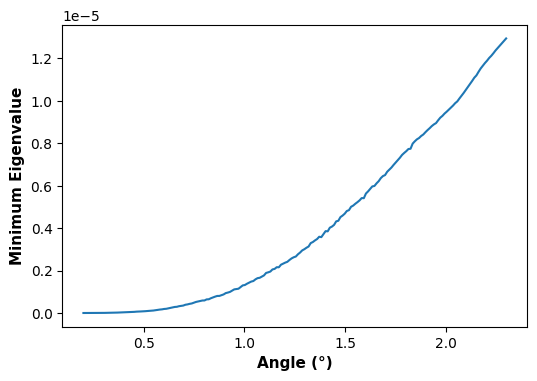

In [5]:
initial_angle_times = [] # No angles measured so far.
angle_1 = angle_choice(sample, initial_angle_times, angle_range, points, time, save_path, 'angle_choice_1')
print('First angle choice: {}'.format(round(angle_1, 2)))

***
### Second Angle
We can also look at subsequent angles. For this sample, it appears that measuring the same angle for longer is optimal until we reach a counting time of around 6 times longer than our initial time. You will see the improvement in the low angle range as the counting time is adjusted.

>>> 0/200
>>> 100/200
Second angle choice: 0.63


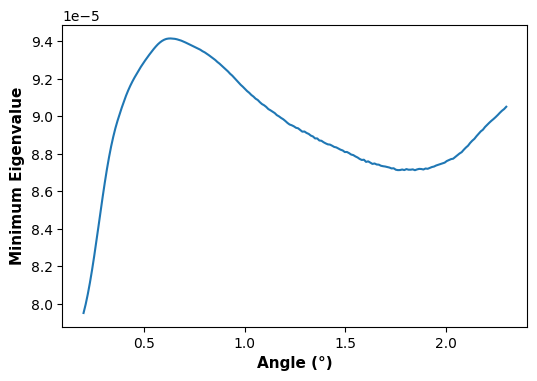

In [6]:
x = 6 # Change x to adjust the counting time.
initial_angle_times = [(angle_1, points, time*x)] # (Angle, Points, Time)
angle_2 = angle_choice(sample, initial_angle_times, angle_range, points, time, save_path, 'angle_choice_2')
print('Second angle choice: {}'.format(round(angle_2, 2)))

***
### Time Dependence

Instead of manually investigating different counting times, we can create an animation of how the choice of second angle will change as the measurement time of the initial angle increases.

Click the ▶ button in the plot below to play the animation.

In [7]:
angle_range = np.linspace(0.2, 2.3, 50)
time_range = np.linspace(0, time*7, 20)
anim = angle_choice_with_time(sample, angle_1, angle_range, time_range, points, time, save_path)
HTML(anim.to_jshtml(default_mode='reflect')) # Converting to JavaScript HTML requires recalculation.

>>> 0/20
>>> 5/20
>>> 10/20
>>> 15/20
>>> 0/20
>>> 5/20
>>> 10/20
>>> 15/20


***
### Optimisation

So far, our experimental design has involved quite a lot of manual work. Instead of investigating individual plots like above, we can define a fixed time budget and number of angles, and apply an established optimisation algorithm to find the optimal solution for us.

Here we apply the differential evolution algorithm to find the optimal angles to measure and the split of measurement times between them.

In [8]:
optimiser = Optimiser(sample)
num_angles = 2 # Number of angles to optimise.

# Find the optimal angles and times using differential evolution.
angles, splits, _ = optimiser.optimise_angle_times(num_angles, angle_bounds=(0.2, 2.3), verbose=False)

# Calculate the counting times from the splits using total counting time of 100.
times = np.array(splits) * 100

print('Angles: {}'.format(np.round(angles, 2)))
print('Times: {}'.format(np.round(times, 1)))

Angles: [0.64 2.3 ]
Times: [11.3 88.7]


As can be seen, the results strongly agree with our above findings.